In [603]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk   

In [604]:
import warnings
warnings.filterwarnings('ignore')

In [618]:
df = pd.read_csv("all_ico_data.csv")
# df = pd.read_csv("icos2017.csv")

## Cleaning data
    ## 1. remove "," from financial datas 
    ## 2. convert rating columns to type float


for i in df.index:
    try:
        if (type(df['hardcap'][i]) == str):
            df['hardcap'][i] = df['hardcap'][i].replace(",","")
                          
        if type(df['ih_raised'][i]) == str:
            df['ih_raised'][i] = df['ih_raised'][i].replace(",","")                      
            
        if (type(df['softcap'][i]) == str):
            df['softcap'][i] = df['softcap'][i].replace(",","")
     
    except Exception as e:
        pass
    
    
## fill na/- values present in aggregate with corresponding values of icobench or icomarks

for index in df.index:
    a_r =  df['aggregate_rating'][index]
    im_r =  df['icomarks_rating'][index]
    ib_r =  df['icobench_rating'][index]
    if (a_r == '-' and (im_r != '-' or ib_r != '-')):
        try:
            if im_r != '-':
                df['aggregate_rating'][index] = float(im_r)
            else:
                 df['aggregate_rating'][index] = float(ib_r)
                        
        except Exception as e:
            print(e)

## Create a subset dataframe out of main df excluding relavtively less important columns/or with most NaN values
sub_df = df.drop(['ticker', 'platform', 'profile_rating', 'date_ended','country','bounty_status','icobazaar_rating'], axis=1) 



In [633]:
## Step 2. convert icomarks rating into scaling of 5 from 10 !!! ????

## Drop all the rows whose column values from aggreagate rating with NaN and other least relevant columns

sub_df = sub_df.dropna(subset=['ih_raised','softcap','ih_softcap','aggregate_rating'])

## dataframe of only ratings columns being considered 

# df_ratings = sub_df[['icobench_rating', 'icomarks_rating','aggregate_rating']]

## 1. Create subset dataframe with only caps and rating columns to determine correlation among the caps and the ratings
## 2. Create subset dataframe with only caps and social activities to determine correlation among the caps and the social activities

df_fundsVsIcoRating = sub_df[['ico_name', 'hardcap','softcap', 'raised',
       'ih_hardcap', 'ih_softcap','ih_raised','team_rating_ib', 
        'team_rating_im', 'product_rating', 'vision_rating','icobench_rating', 'icomarks_rating', 'aggregate_rating']]

df_fundsVsIcoRating.drop_duplicates(subset=['ico_name'], keep='first', inplace=True, ignore_index=False);


In [639]:
### Add column with listing of amount raised in % based on softcap of the ico

amount = raised_sc_pc = percent_raised = 0
raised_pc =[]
funds = df_fundsVsIcoRating
count = 0

for i in df_fundsVsIcoRating.index:    
    try:
        hardcap = float(df_fundsVsIcoRating['ih_hardcap'][i])
        raised_percentage_hc = float(df_fundsVsIcoRating['ih_raised'][i])   
        softcap = float(df_fundsVsIcoRating['ih_softcap'][i])
    
        try:
            amount_raised = raised_percentage_hc * hardcap 
            raised_percentage_sc = round((amount_raised / softcap),2)
            count = count + 1

        except Exception as e:
            print("EXCEPTION",e)
            pass
    except Exception as e:
#         print(e, funds['ico_name'][i],funds['raised'][i],funds['ih_raised'][i])
        print(e, df_fundsVsIcoRating['ico_name'][i],df_fundsVsIcoRating['raised'][i],df_fundsVsIcoRating['ih_raised'][i])                  

            
    if raised_percentage_sc >= 100:
        raised_percentage_sc = 100   
    df_fundsVsIcoRating['raised_percentage_sc'][i]= raised_percentage_sc;

                      
df_fundsVsIcoRating.columns

Index(['ico_name', 'hardcap', 'softcap', 'raised', 'ih_hardcap', 'ih_softcap',
       'ih_raised', 'team_rating_ib', 'team_rating_im', 'product_rating',
       'vision_rating', 'icobench_rating', 'icomarks_rating',
       'aggregate_rating', 'raised_percentage_sc'],
      dtype='object')

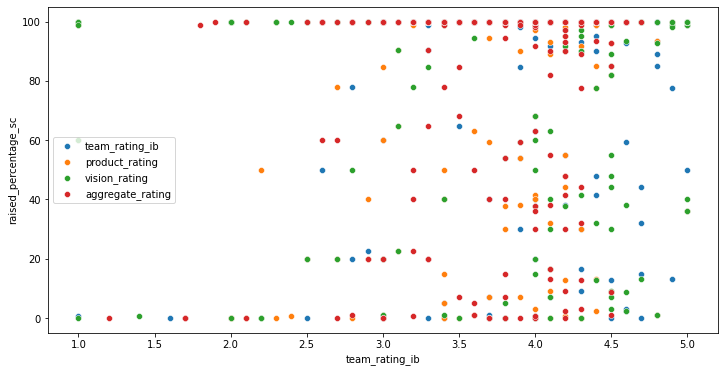

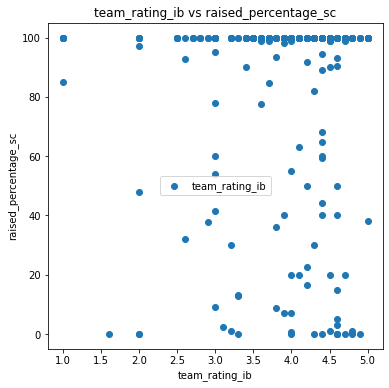

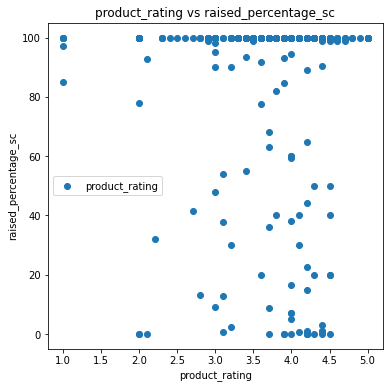

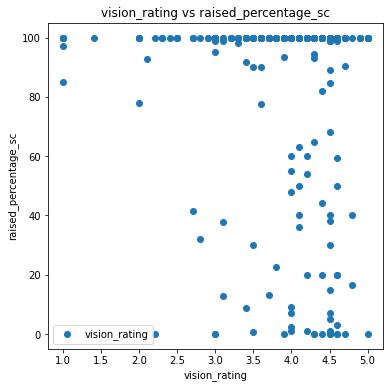

<Figure size 432x432 with 0 Axes>

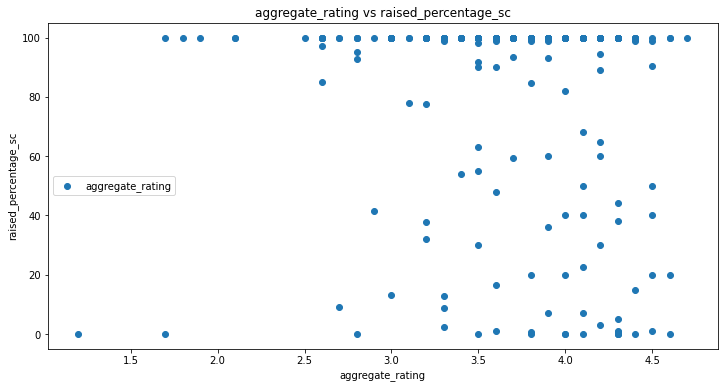

In [640]:
## Drop off capital columns and other other repetitive features

df_fundsVsIcoRating = df_fundsVsIcoRating[['raised_percentage_sc','team_rating_ib','product_rating',
       'vision_rating', 'aggregate_rating']]

df_fundsVsIcoRating = df_fundsVsIcoRating.dropna()

## Scatter plots 

cols = features = df_fundsVsIcoRating.drop(['raised_percentage_sc'],axis=1)
index = target = df_fundsVsIcoRating['raised_percentage_sc']

## 1. All scatterplots in one 

plt.figure(figsize=(12,6));
for col in features.columns:
    col_index= features.columns.get_loc(col)
    if col == "aggregate_rating":      
        features[col] = features[col].astype(float)
        features = features.sort_values(by='aggregate_rating',ascending = True) 


    sns.scatterplot(features.iloc[:,col_index], target, label=col);
# print(features.aggregate_rating.values)
## 2. Individual Scatter plot for each indepedent variables against dependent variable
 
for col in features.columns:
    figure = plt.figure(figsize=(6,6));    
    
    if col == "aggregate_rating":
        plt.figure(figsize=(12,6));
        features = features.sort_values(by='aggregate_rating',ascending = True)  
    
    ax = plt.gca();
    ax.scatter(features[col],target,label=col);
    ax.set_xlabel(col)
    ax.set_ylabel("raised_percentage_sc")

    ax.set_title("{} vs {}".format(col, 'raised_percentage_sc'));
    print("\n") 

    plt.legend();
    plt.show();

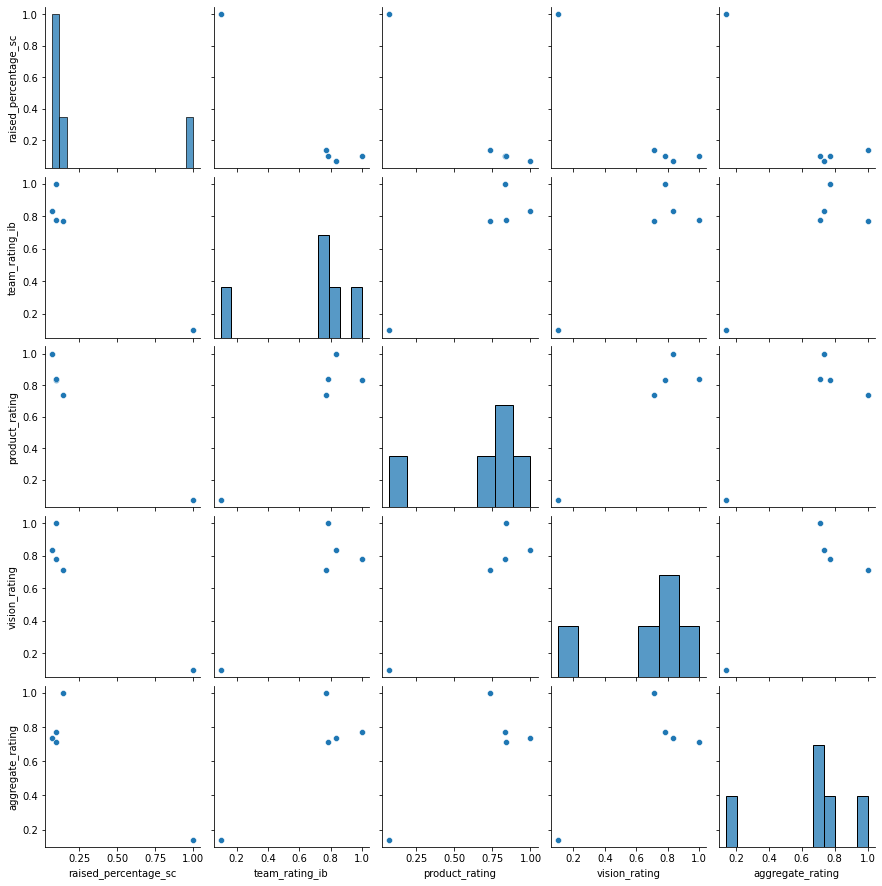

In [641]:
from scipy.stats import pearsonr

values = df_fundsVsIcoRating.astype(float).values

sns.pairplot(df_fundsVsIcoRating.astype(float).corr())


In [679]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Training 

for col in df_fundsVsIcoRating.columns:
    df_fundsVsIcoRating[col] = df_fundsVsIcoRating[col].astype(float)
    
train_X, test_x, train_Y,test_y = train_test_split(features,target, test_size = 0.2)

## 3.1. Linear Regression with all features against 'raised_percentage_sc'

reg = LinearRegression().fit(train_X,train_Y)
lin_reg_all_features = LinearRegression().fit(features, target)

## linear regression of individual feature vs 'aggregate_rating'

Y1 = df_fundsVsIcoRating.raised_percentage_sc.values.reshape(-1,1)
X1 = df_fundsVsIcoRating.aggregate_rating.values.reshape(-1,1)
    
lin_reg = LinearRegression().fit(X1,Y1)
 
## correlation table for each column with corresponding p-value

ico_rating_vs_amount_corr = pd.DataFrame(columns=['corr', 'p_value'])
for col in df_fundsVsIcoRating.columns:
    corr,p_value = stats.pearsonr(df_fundsVsIcoRating[col],df_fundsVsIcoRating['raised_percentage_sc'])
    ico_rating_vs_amount_corr.loc[col] =[round(corr,3),round(p_value,3)]


print("linear coef [raised_percentage_sc vs aggregate_rating] = ",lin_reg.coef_,
       "\nlinear coef [all_ratings vs aggregate_rating] = {}".format(lin_reg_all_features.coef_))
social_vs_amount_corr 

linear coef [raised_percentage_sc vs aggregate_rating] =  [[8.11969331]] 
linear coef [all_ratings vs aggregate_rating] = [ 2.17240685 -4.66535854 -1.66828359  0.34746224]


,corr,p_value
raised_percentage_sc,1.000,0.000
team_rating_ib,0.098,0.103
product_rating,0.071,0.242
vision_rating,0.099,0.100
aggregate_rating,0.141,0.019


In [658]:
from sklearn.linear_model import Ridge

ridge_model = Ridge().fit(features, target)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

ridge.fit(train_X, train_Y)

# print(ridge.score(test_x, test_y),ridge.score(train_X, train_Y))
ridge_model.coef_, ridge.coef_

(array([ 2.07488318, -4.53786942, -1.67778865,  0.33166765]),
 array([ 0.80008024, -0.85633057, -3.16148174,  1.56301743]))

In [659]:
 ## 2. Lasso Regression
    
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(train_X,train_Y)  

print(lasso_reg.coef_)
test = lasso_reg.score(test_x,test_y)
train = lasso_reg.score(train_X,train_Y)



[ 0.         -0.         -2.29454059  0.        ]


,team_rating_ib,product_rating,vision_rating,aggregate_rating
999,4.3,3.8,4.4,4.0
709,4.3,4.1,4.2,4.2
559,4.3,3.7,3.9,4.0
212,4.4,4.0,5.0,3.4
91,4.5,4.2,4.4,4.3
...,...,...,...,...
30,4.6,4.2,4.5,4.4
7,2.0,2.0,3.0,1.7
96,3.6,3.4,3.5,3.6
1512,2.0,3.0,4.0,3.6


In [647]:
### Analysing amount raised against social activities in twitter, telegram and other social networks 

In [646]:
df2 = df[['ico_name', 'hardcap','softcap', 'raised',
       'ih_hardcap', 'ih_softcap','ih_raised','facebook_status','twitter_status', 'telegram_status', 'social_rating']]
df2.drop_duplicates(subset=['ico_name'], keep='first', inplace=True, ignore_index=False);

amounts = []
raised_percentage_sc = 0
for i in df2.index:
#     print(i)
    try:
        hardcap = float(df['ih_hardcap'][i])
        raised_percentage_hc = float(df['ih_raised'][i])   
        softcap = float(df['ih_softcap'][i])
    
        try:
            amount_raised = raised_percentage_hc * hardcap 
            raised_percentage_sc = round((amount_raised / softcap),1)
#             count = count + 1
            if raised_percentage_sc >= 100:
              raised_percentage_sc = 100 
# #             print(raised_percentage_sc)
            amounts.append(raised_percentage_sc)         
        except Exception as e:
            print("EXCEPTION",e)
            j = j+1
            
    except Exception as e:
#         print(e)
        amounts.append(raised_percentage_sc)
        pass
df2['raised_percentage_sc']= amounts          


In [647]:
### Change data types for social rating columns to float from string

social_cols = ['telegram_status', 'facebook_status','twitter_status','social_rating']
for col in df2.columns:
    if col in social_cols:       
        for index in df2.index:
            value = df2[col][index]
            if value == '-' :#or value == "Benchy":
                df2[col][index] = df2[col][index].replace('-','')
            if value == "Benchy":               
                df2[col][index] = df2[col][index].replace("Benchy","")
            try:
                df2[col][index] = float(df2[col][index])                    
            except Exception as e:
                pass
        df2 = df2.replace(r'^\s*$', np.nan, regex=True)
        df2[col] = df2[col].astype(float)


Linear Regression coef = [[5.97286715]], Ridge regression coef = [[5.9654539]], Lasso coef = [5.52947308]


,facebook_status,raised_percentage_sc
facebook_status,1.000000,0.204943
raised_percentage_sc,0.204943,1.000000


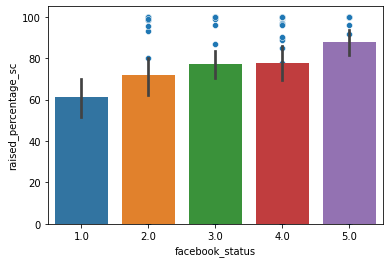

In [648]:
### Subset of dataframe 'df2' with only two columns for analysis of individual correlation with amount raised 

    ## 1. Soical ('facebook') Vs Amount raised 

df2_social_fb = df2[['ico_name','facebook_status','raised_percentage_sc']]
df2_social_fb = df2_social_fb.dropna()

sns.scatterplot(df2.facebook_status,df2.raised_percentage_sc)
sns.barplot('facebook_status','raised_percentage_sc', data=df2_social_fb)

X = df2_social_fb.facebook_status.values.reshape(-1,1)
Y = df2_social_fb.raised_percentage_sc.values.reshape(-1,1)
## Linear Regression 
social_lin_reg = LinearRegression().fit(X,Y)


## Ridge Regression 
ridge_model = Ridge().fit(X,Y)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

## Lassoo 
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(X,Y)  

print("Linear Regression coef = {}, Ridge regression coef = {}, Lasso coef = {}".format(social_lin_reg.coef_,ridge_model.coef_, lasso_reg.coef_))
df2_social_fb.corr()


Linear Regression coef = [[5.71253376]], Ridge regression coef = [[5.70536321]], Lasso coef = [5.26712069]


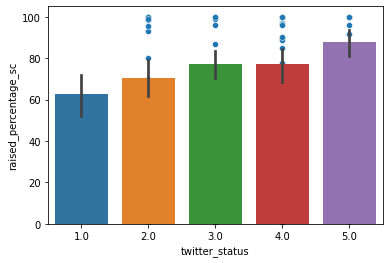

In [461]:

 ## 2. Twitter ratings Vs Amount raised 
df2_twitter = df2[['twitter_status','raised_percentage_sc']]

df2_twitter = df2_twitter.dropna()

sns.scatterplot(df2_twitter.twitter_status,df2_twitter.raised_percentage_sc)
sns.barplot('twitter_status','raised_percentage_sc', data=df2_twitter)

X = df2_twitter.twitter_status.values.reshape(-1,1)
Y = df2_twitter.raised_percentage_sc.values.reshape(-1,1)
## Linear Regression 
twitter_lin_reg = LinearRegression().fit(X,Y)


## Ridge Regression 
ridge_model = Ridge().fit(X,Y)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

## Lassoo 
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(X,Y)  

print("Linear Regression coef = {}, Ridge regression coef = {}, Lasso coef = {}".format(twitter_lin_reg.coef_,ridge_model.coef_, lasso_reg.coef_))


Linear Regression coef = [[10.54102338]], Ridge regression coef = [[10.48542482]], Lasso coef = [10.0319871]


,telegram_status,raised_percentage_sc
telegram_status,1.000000,0.301203
raised_percentage_sc,0.301203,1.000000


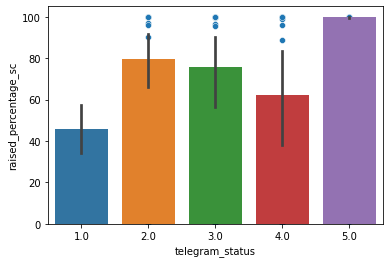

In [463]:
### 3. telegram ratings Vs Amount raised 


df2_telegram = df2[['telegram_status','raised_percentage_sc']]

df2_telegram = df2_telegram.dropna()

sns.scatterplot(df2.telegram_status,df2.raised_percentage_sc)
sns.barplot('telegram_status','raised_percentage_sc', data=df2_telegram)

df2_telegram.corr()

X = df2_telegram.telegram_status.values.reshape(-1,1)
Y = df2_telegram.raised_percentage_sc.values.reshape(-1,1)
## Linear Regression 
lin_reg = LinearRegression().fit(X,Y)


## Ridge Regression 
ridge_model = Ridge().fit(X,Y)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

## Lassoo 
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(X,Y)  

print("Linear Regression coef = {}, Ridge regression coef = {}, Lasso coef = {}".format(lin_reg.coef_,ridge_model.coef_, lasso_reg.coef_))

df2_telegram.corr()

Linear Regression coef = [[4.02741741]], Ridge regression coef = [[4.0247441]], Lasso coef = [3.88235179]


,social_rating,raised_percentage_sc
social_rating,1.000000,0.260312
raised_percentage_sc,0.260312,1.000000


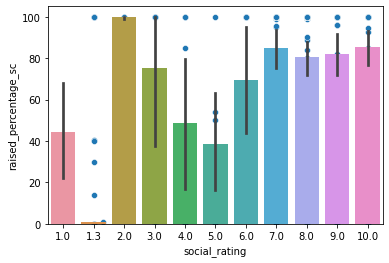

In [464]:
### 2. Overall social activity rating Vs Amount raised 

df2_social_rating = df2[['ico_name','social_rating','raised_percentage_sc']]

df2_social_rating = df2_social_rating.dropna()

sns.scatterplot(df2.social_rating,df2.raised_percentage_sc)
sns.barplot('social_rating','raised_percentage_sc', data=df2_social_rating)



X = df2_social_rating.social_rating.values.reshape(-1,1)
Y = df2_social_rating.raised_percentage_sc.values.reshape(-1,1)

## Linear Regression 
lin_reg = LinearRegression().fit(X,Y)


## Ridge Regression 
ridge_model = Ridge().fit(X,Y)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

## Lassoo 
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(X,Y)  

print("Linear Regression coef = {}, Ridge regression coef = {}, Lasso coef = {}".format(lin_reg.coef_,ridge_model.coef_, lasso_reg.coef_))
df2_social_rating.corr()

In [465]:
## Analysing correlation of all social rating over amount raised collectively

df2_socialRatingsVsRaised = df2[['ico_name','facebook_status', 'twitter_status', 'telegram_status',
       'social_rating', 'raised_percentage_sc']]
df2_socialRatingsVsRaised.dropna(inplace=True)

In [534]:
### Separating datas for regression analysis of social ratings vs amount raised

count = 0

all_social_features_df = df2[['facebook_status','twitter_status','telegram_status','social_rating','raised_percentage_sc']]
all_social_features_df = all_social_features_df.dropna()

X = all_social_features_df.drop(['raised_percentage_sc'], axis = 1)
Y = all_social_features_df['raised_percentage_sc']

## Linear Regression 
lin_reg = LinearRegression().fit(X,Y)

## Ridge Regression 
ridge_model = Ridge().fit(X,Y)
ridge = Ridge(alpha=50, max_iter=100, tol=0.1)

## Lassoo 
lasso_reg = linear_model.Lasso(alpha= 0.8, max_iter=100, tol=0.1)
lasso_reg.fit(X,Y)  

print("Linear Regression coef = {},\n Ridge regression coef = {}, \n Lasso Regression coef = {}".format(lin_reg.coef_,ridge_model.coef_, lasso_reg.coef_))
all_social_features_df.corr()

## p-value

social_vs_amount_corr = pd.DataFrame(columns=['corr', 'p_value'])
for col in X.columns:
    corr,p_value = stats.pearsonr(X[col],Y)
    social_vs_amount_corr.loc[col] =[round(corr,3),round(p_value,3)]

social_vs_amount_corr 


Linear Regression coef = [ 17.32418632 -12.47381608   8.83481603   4.66062499],
 Ridge regression coef = [ 15.73051529 -10.62295295   8.81933944   4.48942225], 
 Lasso Regression coef = [ 8.51984725 -1.63370284  8.70336493  3.48895957]


,corr,p_value
facebook_status,0.491,0.000
twitter_status,0.430,0.001
telegram_status,0.437,0.001
social_rating,0.399,0.002


In [236]:
## calculate for corr and p-value 

from scipy import stats

social_vs_amount_corr = pd.DataFrame(columns=['corr', 'p_value'])
social_vs_amount_corr

for col in X1:
    corr,p_value = stats.pearsonr(X1.raised_percentage_sc,X1[col])
    social_vs_amount_corr.loc[col] =[round(corr,3),round(p_value,3)]

social_vs_amount_corr
    

AttributeError: 'numpy.ndarray' object has no attribute 'raised_percentage_sc'

In [143]:
# df = pd.read_csv("all_ico_data.csv")
df = pd.read_csv("icos2017.csv")

df.columns
for i in df.index:
    try:
        if (type(df['hardcap'][i]) == str):# and "," in df['hardcap'][i]) or (type(df['ih_hardcap'][i]) == str and "," in df['ih_hardcap'][i]) : 
#             print(i, ".hardap>>", df['ico_name'][i], df['hardcap'][i])
            df['hardcap'][i] = df['hardcap'][i].replace(",","")
           
        if type(df['ih_raised'][i]) == str:# and "," in df['ih_raised'][i]:
#             print(i, ".ico_Raised>>", df['ico_name'][i], df['ih_raised'][i])
            df['ih_raised'][i] = df['ih_raised'][i].replace(",","")            

            
        if (type(df['softcap'][i]) == str):# and "," in df['softcap'][i]) or (type(df['ih_softcap'][i]) == str and "," in df['ih_softcap'][i]) : 
            #print(i, ".hardap>>", df['ico_name'][i], df['hardcap'][i])
            df['softcap'][i] = df['softcap'][i].replace(",","")
            
            
    except Exception as e:
        pass

df_2017 = df
df_2017 =df_2017.replace(r'^\s*$', np.nan, regex=True)
df_2017_typeA=df_2017[['hardcap','softcap', 'raised', 'ih_hardcap', 'ih_softcap', 'ih_raised', 'team_rating_ib', 'team_rating_im', 'product_rating',
       'vision_rating', 'icobench_rating', 'icomarks_rating', 'aggregate_rating']]
# df_2017_typeA = df_2017_typeA.dropna(how='all')
# df_2017_typeA['ico_name'] = df_2017[['ico_name']]
df_2017_typeA
df_2017_typeA.insert(loc=0, column='ico_name', value = df_2017['ico_name'])
df_2017_typeA['hardcap'] = df_2017_typeA['hardcap'].astype(float)
df_2017_typeA['softcap'] = df_2017_typeA['softcap'].astype(float)
df_2017_typeA['raised'] = df_2017_typeA['raised'].astype(float)
df_2017_typeA['ih_hardcap'] = df_2017_typeA['ih_hardcap'].astype(float)
df_2017_typeA['ih_softcap'] = df_2017_typeA['ih_softcap'].astype(float)
df_2017_typeA['ih_raised'] = df_2017_typeA['ih_raised'].astype(float)

for index in df_2017_typeA.index:
    hc = df_2017_typeA['hardcap'][index]
    sc =  df_2017_typeA['softcap'][index]
    raised = df_2017_typeA['raised'][index]
    ih_hc = df_2017_typeA ['ih_hardcap'][index]
    ih_sc = df_2017_typeA ['ih_softcap'][index]
    ih_raised = df_2017_typeA ['ih_raised'][index]
    
#     if hc.isna() and sc.isna() and raised.isna()and ih_hc.isna() and ih_sc.isna() and ih_raised.isna():
#         df_2017_typeA = df_2017_typeA.drop(index)
        
#     for cols in df_2017_typeA.columns:
  
# df_2017_typeA.iloc[1:7,1:7]    

ValueError: could not convert string to float: '100 BTC'

In [ ]:
# df2 = df2.sort_values(by=['facebook_status','raised_percentage_sc'])
# df2.dropna(subset=['raised_percentage_sc'], inplace = True)

## Subset of dataframe 'df2' with only two columns for analysis of individual correlation with amount raised 

### 1. Soical ('facebook') Vs Amount raised 

df2_social_fb = df2[['facebook_status','raised_percentage_sc']]
# for index in df2_social.index:
#     if df2_social['facebook_status'][index] == '-':
#         df2_social['facebook_status'][index] = df2_social['facebook_status'][index].replace("-","")
#     try:
#         df2_social['facebook_status'][index] = float(df2_social['facebook_status'][index])
   
#     except Exception as e:
# #         print (e)
#         pass

# df2_social =df2_social.replace(r'^\s*$', np.nan, regex=True)
df2_social_fb = df2_social_fb.dropna()
# df2_social_fb['facebook_status'] = df2_social_fb['facebook_status'].astype(float)

sns.scatterplot(df2.social_rating,df2.raised_percentage_sc)
sns.barplot('facebook_status','raised_percentage_sc', data=df2_social_fb)

df2_social_fb.corr()
social_reg = LinearRegression().fit(df2_social_fb.facebook_status.values.reshape(-1,1),df2_social_fb.raised_percentage_sc.values.reshape(-1,1))
social_reg.coef_